In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

## 4 Special Moves

In [2]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
bart = ChangeNumTreeBART(ndpost=10000, nskip=10000, n_trees=100, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0 = 100, theta_df = np.inf, 
                         tree_num_prior_type="poisson")
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 20000/20000 [01:11<00:00, 278.28it/s]


In [4]:
bart.trace[-1].n_trees

45

In [5]:
bart.trace[-1].global_params

{'eps_sigma2': array([0.00059374]), 'ntree_theta': 100}

In [6]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

38.7738

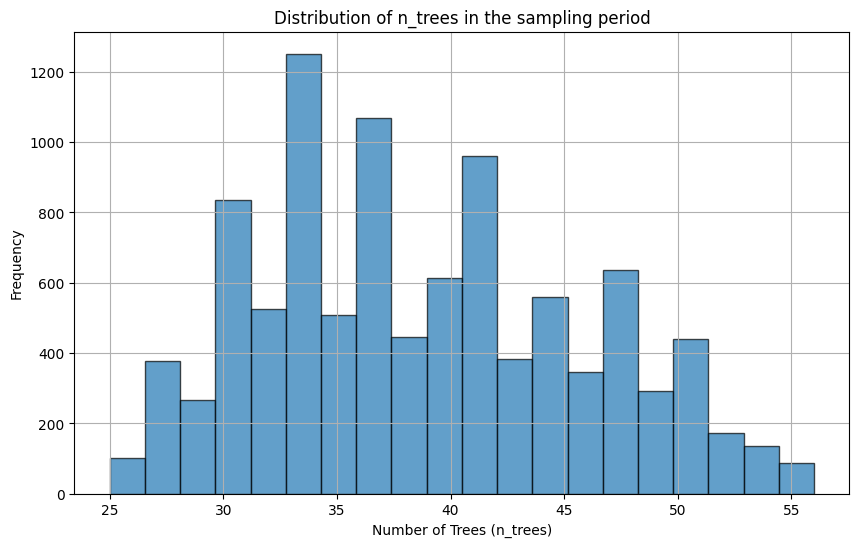

In [7]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

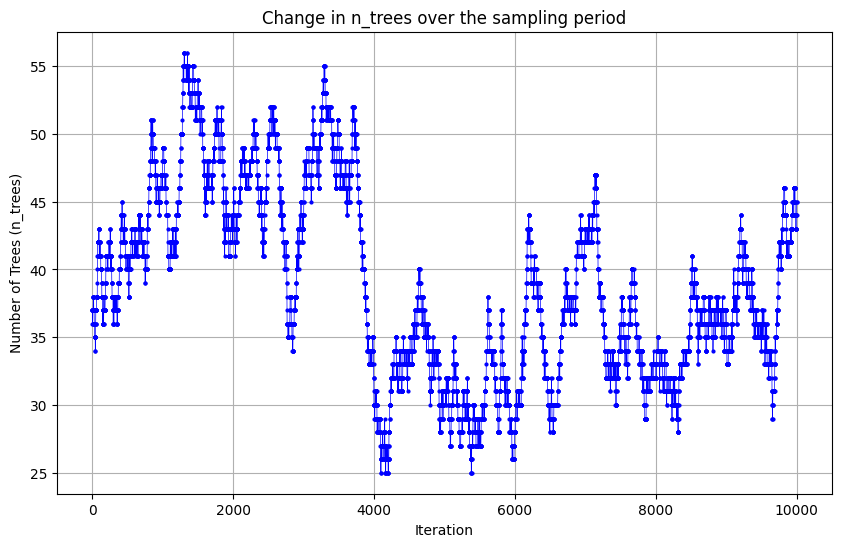

In [8]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [9]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-04-05 01:31:41,328:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-04-05 01:31:41,332:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.42 P_prune=0.58 A_grow=0.21 A_prune=0.27 (burnin)
Iteration 200/300 P_grow=0.51 P_prune=0.49 A_grow=0.22 A_prune=0.27
Iteration 300/300 P_grow=0.42 P_prune=0.58 A_grow=0.37 A_prune=0.27


In [10]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.15604198742198794,
 'rf': 0.02316698052699029,
 'lr': 0.048045521328019404,
 'btz': 0.02639905953788973}

In [11]:
y_test

array([ 0.57494339, -0.39107825,  0.03833771, -0.10585361,  0.58205285,
       -0.46879905, -0.12964723,  0.48524713,  0.30069396,  0.48688625,
        0.49330468,  0.4528224 ,  0.5750869 ,  0.55541165,  0.43010696,
        0.6155312 ,  0.44660998,  0.51601906,  0.48824578,  0.18206462,
        0.37483528, -0.15720403,  0.57823503,  0.43025762,  0.56087615,
        0.49741372, -0.02658388,  0.4874991 ,  0.04278904, -0.06782644,
       -0.03427862,  0.54396366,  0.52023062, -0.14805365,  0.61774119,
        0.54746971,  0.58137637, -0.46316434,  0.29964777,  0.55300647])

In [12]:
btpred

array([ 0.37715077, -0.3424932 , -0.07381498,  0.26641545,  0.5615127 ,
       -0.34695777,  0.26163787,  0.5636773 ,  0.54433095,  0.3950597 ,
        0.43353567,  0.6393476 ,  0.52455026,  0.37809563,  0.41952783,
        0.46329904,  0.5766285 ,  0.54002595,  0.47985736,  0.31361273,
        0.5410062 ,  0.13593051,  0.5105466 ,  0.52105355,  0.48496237,
        0.5599343 , -0.31542704,  0.37501675,  0.03948653,  0.19099396,
        0.0162322 ,  0.4067271 ,  0.43013087,  0.0736673 ,  0.52277017,
        0.41233432,  0.3946005 , -0.44801572,  0.5167826 ,  0.49665236],
      dtype=float32)

In [13]:
y_pred = bart.predict(X_test)
y_pred

array([0.05606159, 0.06457745, 0.05110323, 0.07377144, 0.03351862,
       0.0739448 , 0.08842606, 0.06998245, 0.05570526, 0.05748788,
       0.11686615, 0.07820152, 0.0512167 , 0.04769176, 0.07208766,
       0.05877012, 0.0745851 , 0.07845606, 0.08328487, 0.04279435,
       0.07500207, 0.06906737, 0.06022947, 0.07340576, 0.07790313,
       0.0689114 , 0.0636876 , 0.07320257, 0.07107746, 0.07447655,
       0.09882087, 0.09489838, 0.08661306, 0.05904344, 0.08651   ,
       0.05677158, 0.11425148, 0.07536788, 0.08297173, 0.07981935])